## Content

- **Data Cleaning / Cleasing**
    - Noisy Data
    - Missing Data Analysis
    - Outlier Detection
- **Data Standardization / Feature Scaling**
    - Normalization(0-1 Scaling)
    - Standardization(Z Score Scaling)
    - Min-Max Scaling
    - Binary Transformation
- **Variable Transformation**
    - Label Encoding
    - One Hot Encoding

## Importing Libraries

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import math

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt

In [6]:
from sklearn.neighbors import LocalOutlierFactor

In [4]:
import missingno as msno

In [5]:
!pip install ycimpute

In [9]:
from ycimpute.imputer import knnimput

In [10]:
from ycimpute.imputer import iterforest

In [11]:
from ycimpute.imputer import EM

In [18]:
from sklearn import preprocessing

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
from sklearn.preprocessing import OneHotEncoder

## Data Cleaning / Cleasing

### Outlier Detection

In statistics, an outlier is a data point that differs significantly from other observations. An outlier may be due to variability in the measurement or it may indicate experimental error; the latter are sometimes excluded from the data set. An outlier can cause serious problems in statistical analyses.

**How to Identify Outliers in our Data?**

**Mean and Standard Deviation Method:** For this outlier detection method, the mean and standard deviation of the residuals are calculated and compared. If a value is a certain number of standard deviations away from the mean, that data point is identified as an outlier. The specified number of standard deviations is called the threshold. The default value is 3. This method can fail to detect outliers because the outliers increase the standard deviation. The more extreme the outlier, the more the standard deviation is affected.

**Z Score:** Z score is an important concept in statistics. Z score is also called standard score. This score helps to understand if a data value is greater or smaller than mean and how far away it is from the mean. More specifically, Z score tells how many standard deviations away a data point is from the mean.

**IQR-Boxplot:** For this outlier detection method, the median of the residuals is calculated, along with the 25th percentile and the 75th percentile. The difference between the 25th and 75th percentile is the interquartile deviation (IQD). Then, the difference is calculated between each historical value and the residual median. If the historical value is a certain number of Median Absolute Deviation(MAD) away from the median of the residuals, that value is classified as an outlier. The default threshold is 2.22, which is equivalent to 3 standard deviations or MADs. This method is somewhat susceptible to influence from extreme outliers, but less so than the mean and standard deviation method. Box plots are based on this approach. The median and interquartile deviation method can be used for both symmetric and asymmetric data.

- lower inner fence: Q1 - 1.5*IQ
- upper inner fence: Q3 + 1.5*IQ
- lower outer fence: Q1 - 3*IQ
- upper outer fence: Q3 + 3*IQ

**Outlier Detection**

For a real world example, we will use *diamonds* dataset from seaborn.

In [15]:
df = sns.load_dataset("diamonds")
df = df.select_dtypes(include=["float64","int64"])
df.dropna(inplace=True)
df.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [16]:
df.shape

(53940, 7)

In [17]:
df_table = df["table"]
df_table.head()

0    55.0
1    61.0
2    65.0
3    58.0
4    58.0
Name: table, dtype: float64

Let's plot table variable in order to see outliers.

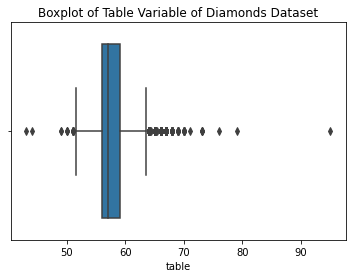

In [18]:
sns.boxplot(x=df_table)
plt.title("Boxplot of Table Variable of Diamonds Dataset")
plt.show()

In [19]:
df_table.describe()

count    53940.000000
mean        57.457184
std          2.234491
min         43.000000
25%         56.000000
50%         57.000000
75%         59.000000
max         95.000000
Name: table, dtype: float64

Let's calculate the IQR.

In [20]:
quantile1 = df_table.quantile(0.25)
quantile3 = df_table.quantile(0.75)
IQR = quantile3-quantile1

print("Q1: ", quantile1)
print("Q3: ", quantile3)
print("IQR: ", IQR)

Q1:  56.0
Q3:  59.0
IQR:  3.0


In [21]:
lower_inner_fence = quantile1 - 1.5*IQR
upper_inner_fence = quantile3 + 1.5*IQR

In [22]:
print("lower_inner_fence",lower_inner_fence)
print("upper_inner_fence",upper_inner_fence)

lower_inner_fence 51.5
upper_inner_fence 63.5


In [23]:
print("Number of Outliers: ",len(df_table[(df_table<lower_inner_fence) | (df_table>upper_inner_fence)]))

Number of Outliers:  605


**Solutions for Bivariate Outliers**

**1. Deleting the outlier observations**

In [24]:
df_table = pd.DataFrame(df_table)
df_table.head()

,table
0,55.0
1,61.0
2,65.0
3,58.0
4,58.0


In [25]:
df_table.shape

(53940, 1)

In [26]:
new_df = df_table[~((df_table<lower_inner_fence) | (df_table>upper_inner_fence)).any(axis=1)]

In [27]:
new_df.shape

(53335, 1)

**2. Filling with Average**

In [28]:
df = sns.load_dataset("diamonds")
df = df.select_dtypes(include=["float64","int64"])
df.dropna(inplace=True)
df.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [29]:
df_table = df["table"]
df_table.head()

0    55.0
1    61.0
2    65.0
3    58.0
4    58.0
Name: table, dtype: float64

In [30]:
df_table[(df_table<lower_inner_fence) | (df_table>upper_inner_fence)] = df_table.mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
df_table[(df_table<lower_inner_fence) | (df_table>upper_inner_fence)] # There is no outlier after filling.

Series([], Name: table, dtype: float64)

**3. Suppression of the Outliers**

If a outlier is close to upper bound, we make it upper bound. If it's close to lower bound, we make it lower bound.

In [32]:
df = sns.load_dataset("diamonds")
df = df.select_dtypes(include=["float64","int64"])
df.dropna(inplace=True)
df.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [33]:
df_table = df["table"]
df_table.head()

0    55.0
1    61.0
2    65.0
3    58.0
4    58.0
Name: table, dtype: float64

In [34]:
df_table[(df_table<lower_inner_fence) | (df_table>upper_inner_fence)]

2        65.0
91       69.0
145      64.0
219      64.0
227      67.0
         ... 
53695    65.0
53697    65.0
53756    64.0
53757    64.0
53785    65.0
Name: table, Length: 605, dtype: float64

In [35]:
df_table[df_table<lower_inner_fence] =lower_inner_fence
df_table[df_table>upper_inner_fence] =upper_inner_fence

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Missing Data Analysis

In statistics, missing data, or missing values, occur when no data value is stored for the variable in an observation.

Missing data in the training data set can reduce the power / fit of a model or can lead to a biased model because we have not analysed the behavior and relationship with other variables correctly. It can lead to wrong prediction or classification.

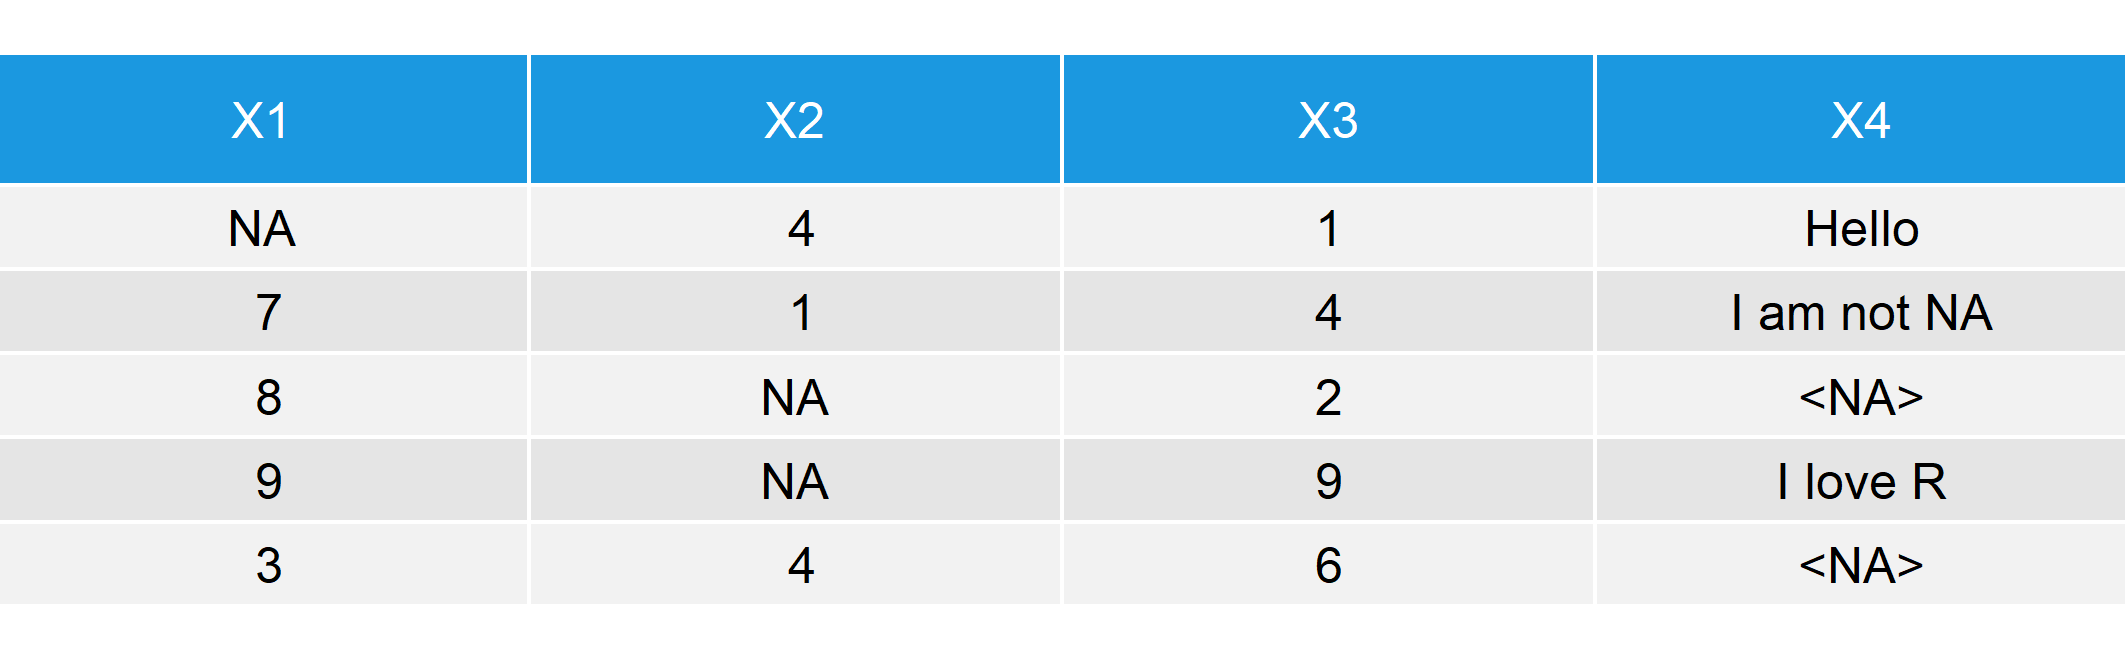

**Solutions for Missing Data**

*1)* Deletion : List Wise Deletion and Pair Wise Deletion

*2)* Mean/ Mode/ Median Imputation

*3)* Prediction Model

*4)* KNN Imputation

**Note:** If a value is missing becuase it doesn't exist (like the height of the oldest child of someone who doesn't have any children) then it doesn't make sense to try and guess what it might be. These values you probably do want to keep as NaN. On the other hand, if a value is missing because it wasn't recorded, then you can try to guess what it might have been based on the other values in that column and row.

**1) Deletion : List Wise Deletion and Pair Wise Deletion**

Deletion methods are used when the nature of missing data is “Missing completely at random” else non random missing values can bias the model output.

In [55]:
C1 = np.array([1,5,np.NaN,42,np.NaN,54,22,85,19,35])
C2 = np.array([42,24,53,3,np.NaN,np.NaN,42,88,9,12])
C3 = np.array([np.NaN,13,53,57,np.NaN,43,76,18,np.NaN,35])
df = pd.DataFrame({"C1":C1,"C2":C2,"C3":C3})

In [56]:
df

,C1,C2,C3
0,1.0,42.0,NaN
1,5.0,24.0,13.0
2,NaN,53.0,53.0
3,42.0,3.0,57.0
4,NaN,NaN,NaN
5,54.0,NaN,43.0
6,22.0,42.0,76.0
7,85.0,88.0,18.0
8,19.0,9.0,NaN
9,35.0,12.0,35.0


In [57]:
df.isna().sum()

C1    2
C2    2
C3    3
dtype: int64

In [58]:
df.notnull().sum()

C1    8
C2    8
C3    7
dtype: int64

In [59]:
df.isna().sum().sum()

7

In [60]:
df[df.isnull().any(axis=1)] # All missing values

,C1,C2,C3
0,1.0,42.0,NaN
2,NaN,53.0,53.0
4,NaN,NaN,NaN
5,54.0,NaN,43.0
8,19.0,9.0,NaN


In [61]:
df[df.notnull().all(axis=1)] # All non-missing values

,C1,C2,C3
1,5.0,24.0,13.0
3,42.0,3.0,57.0
6,22.0,42.0,76.0
7,85.0,88.0,18.0
9,35.0,12.0,35.0


In [62]:
df[df["C1"].isnull() & df["C3"].notnull()]

,C1,C2,C3
2,NaN,53.0,53.0


Let's delete missing values.

In [63]:
df.dropna() # If we want to drop na values permanently, we can say inplace argument True

,C1,C2,C3
1,5.0,24.0,13.0
3,42.0,3.0,57.0
6,22.0,42.0,76.0
7,85.0,88.0,18.0
9,35.0,12.0,35.0


If we want to delete rows that all values are NaN, we can use *how* argument.

In [64]:
df.dropna(how="all") 

,C1,C2,C3
0,1.0,42.0,NaN
1,5.0,24.0,13.0
2,NaN,53.0,53.0
3,42.0,3.0,57.0
5,54.0,NaN,43.0
6,22.0,42.0,76.0
7,85.0,88.0,18.0
8,19.0,9.0,NaN
9,35.0,12.0,35.0


**2) Mean/ Mode/ Median Imputation**

Imputation is a method to fill in the missing values with estimated ones.

In [65]:
C1 = np.array([1,5,np.NaN,42,np.NaN,54,22,85,19,35])
C2 = np.array([42,24,53,3,np.NaN,np.NaN,42,88,9,12])
C3 = np.array([np.NaN,13,53,57,np.NaN,43,76,18,np.NaN,35])
df = pd.DataFrame({"C1":C1,"C2":C2,"C3":C3})

In [66]:
df

,C1,C2,C3
0,1.0,42.0,NaN
1,5.0,24.0,13.0
2,NaN,53.0,53.0
3,42.0,3.0,57.0
4,NaN,NaN,NaN
5,54.0,NaN,43.0
6,22.0,42.0,76.0
7,85.0,88.0,18.0
8,19.0,9.0,NaN
9,35.0,12.0,35.0


Let's give mean of column to NA values.

In [67]:
df["C1"][df["C1"].isnull()] = df["C1"].mean()
df["C2"][df["C2"].isnull()] = df["C2"].mean()
df["C3"][df["C3"].isnull()] = df["C3"].mean()

In [68]:
df

,C1,C2,C3
0,1.000,42.000,42.142857
1,5.000,24.000,13.000000
2,32.875,53.000,53.000000
3,42.000,3.000,57.000000
4,32.875,34.125,42.142857
5,54.000,34.125,43.000000
6,22.000,42.000,76.000000
7,85.000,88.000,18.000000
8,19.000,9.000,42.142857
9,35.000,12.000,35.000000


We can also use **fillna()** function.

In [69]:
C1 = np.array([1,5,np.NaN,42,np.NaN,54,22,85,19,35])
C2 = np.array([42,24,53,3,np.NaN,np.NaN,42,88,9,12])
C3 = np.array([np.NaN,13,53,57,np.NaN,43,76,18,np.NaN,35])
df = pd.DataFrame({"C1":C1,"C2":C2,"C3":C3})

In [70]:
df["C1"].fillna(df["C1"].mean())
df["C2"].fillna(df["C3"].mean())
df["C3"].fillna(df["C2"].mean())

0    34.125
1    13.000
2    53.000
3    57.000
4    34.125
5    43.000
6    76.000
7    18.000
8    34.125
9    35.000
Name: C3, dtype: float64

We can also use **apply()** function.

In [71]:
df.apply(lambda col: col.fillna(col.mean()),axis=0)

,C1,C2,C3
0,1.000,42.000,42.142857
1,5.000,24.000,13.000000
2,32.875,53.000,53.000000
3,42.000,3.000,57.000000
4,32.875,34.125,42.142857
5,54.000,34.125,43.000000
6,22.000,42.000,76.000000
7,85.000,88.000,18.000000
8,19.000,9.000,42.142857
9,35.000,12.000,35.000000


We can also use **where()** function.

In [72]:
df.where(pd.notna(df),df.median(),axis="columns")

,C1,C2,C3
0,1.0,42.0,43.0
1,5.0,24.0,13.0
2,28.5,53.0,53.0
3,42.0,3.0,57.0
4,28.5,33.0,43.0
5,54.0,33.0,43.0
6,22.0,42.0,76.0
7,85.0,88.0,18.0
8,19.0,9.0,43.0
9,35.0,12.0,35.0


We can also impute missing data by categorical variables.

In [73]:
Salary = np.array([12900,5850,np.NaN,7600,np.NaN,6300,7500,8250,11900,9350])
C2 = np.array([42,24,53,3,np.NaN,np.NaN,42,88,9,12])
C3 = np.array([np.NaN,13,53,57,np.NaN,43,76,18,np.NaN,35])
gender = np.array(["F","M","M","M","F","F","F","F","M","M"])
df = pd.DataFrame({"Salary":Salary,"C2":C2,"C3":C3, "Gender":gender})

In [74]:
df

,Salary,C2,C3,Gender
0,12900.0,42.0,NaN,F
1,5850.0,24.0,13.0,M
2,NaN,53.0,53.0,M
3,7600.0,3.0,57.0,M
4,NaN,NaN,NaN,F
5,6300.0,NaN,43.0,F
6,7500.0,42.0,76.0,F
7,8250.0,88.0,18.0,F
8,11900.0,9.0,NaN,M
9,9350.0,12.0,35.0,M


In [75]:
df.groupby("Gender").median()["Salary"]

Gender
F    7875.0
M    8475.0
Name: Salary, dtype: float64

Let's assign values depending on Gender.

In [76]:
df["Salary"].fillna(df.groupby("Gender")["Salary"].transform("median"))

0    12900.0
1     5850.0
2     8475.0
3     7600.0
4     7875.0
5     6300.0
6     7500.0
7     8250.0
8    11900.0
9     9350.0
Name: Salary, dtype: float64

We can also impute categorical variables.

In [77]:
Salary = np.array([12900,5850,np.NaN,7600,np.NaN,6300,7500,8250,11900,9350])
C2 = np.array([42,24,53,3,np.NaN,np.NaN,42,88,9,12])
C3 = np.array([np.NaN,13,53,57,np.NaN,43,76,18,np.NaN,35])
gender = np.array(["F",np.NaN,"M","M",np.NaN,"F","F","F",np.NaN,"M"],dtype=object)
df = pd.DataFrame({"Salary":Salary,"C2":C2,"C3":C3, "Gender":gender})

In [78]:
df

,Salary,C2,C3,Gender
0,12900.0,42.0,NaN,F
1,5850.0,24.0,13.0,NaN
2,NaN,53.0,53.0,M
3,7600.0,3.0,57.0,M
4,NaN,NaN,NaN,NaN
5,6300.0,NaN,43.0,F
6,7500.0,42.0,76.0,F
7,8250.0,88.0,18.0,F
8,11900.0,9.0,NaN,NaN
9,9350.0,12.0,35.0,M


Let's assign mode value of Gender.

In [79]:
df["Gender"].fillna(df.Gender.mode().item())

0    F
1    F
2    M
3    M
4    F
5    F
6    F
7    F
8    F
9    M
Name: Gender, dtype: object

We could also be a bit more savvy and replace missing values with whatever value comes directly after it in the same column. (This makes a lot of sense for datasets where the observations have some sort of logical order to them.) 

We will use *method* argument for that.

In [80]:
df.Gender.fillna(method="bfill")

0    F
1    M
2    M
3    M
4    F
5    F
6    F
7    F
8    M
9    M
Name: Gender, dtype: object

In [81]:
df.Gender.fillna(method="ffill")

0    F
1    F
2    M
3    M
4    M
5    F
6    F
7    F
8    F
9    M
Name: Gender, dtype: object

**3) Prediction Model**

Prediction model is one of the sophisticated method for handling missing data. Here, we create a predictive model to estimate values that will substitute the missing data. In this case, we divide our data set into two sets: One set with no missing values for the variable and another one with missing values. First data set become training data set of the model while second data set with missing values is test data set and variable with missing values is treated as target variable. Next, we create a model to predict target variable based on other attributes of the training data set and populate missing values of test data set.

For a real world example, we will work with *titanic* dataset of Seaborn.

In [82]:
df = sns.load_dataset("titanic")
df = df.select_dtypes(include= ["float64","int64"])
df.head()

,survived,pclass,age,sibsp,parch,fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [83]:
df.isnull().sum()

survived      0
pclass        0
age         177
sibsp         0
parch         0
fare          0
dtype: int64

**4) KNN Imputation**

Here the missing values of an attribute are imputed using the given number of attributes that are most similar to the attribute whose values are missing. The similarity of two attributes is determined using a distance function. 

For a real world example, we will work with *titanic* dataset of Seaborn.

In [91]:
df = sns.load_dataset("titanic")
df = df.select_dtypes(include= ["float64","int64"])
df.head()

,survived,pclass,age,sibsp,parch,fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [92]:
df.isnull().sum()

survived      0
pclass        0
age         177
sibsp         0
parch         0
fare          0
dtype: int64

In [93]:
variables = list(df.columns)

In [94]:
new_df = np.array(df)

In [95]:
new_df.shape

(891, 6)

In [96]:
new_df[:10]

array([[ 0.    ,  3.    , 22.    ,  1.    ,  0.    ,  7.25  ],
       [ 1.    ,  1.    , 38.    ,  1.    ,  0.    , 71.2833],
       [ 1.    ,  3.    , 26.    ,  0.    ,  0.    ,  7.925 ],
       [ 1.    ,  1.    , 35.    ,  1.    ,  0.    , 53.1   ],
       [ 0.    ,  3.    , 35.    ,  0.    ,  0.    ,  8.05  ],
       [ 0.    ,  3.    ,     nan,  0.    ,  0.    ,  8.4583],
       [ 0.    ,  1.    , 54.    ,  0.    ,  0.    , 51.8625],
       [ 0.    ,  3.    ,  2.    ,  3.    ,  1.    , 21.075 ],
       [ 1.    ,  3.    , 27.    ,  0.    ,  2.    , 11.1333],
       [ 1.    ,  2.    , 14.    ,  1.    ,  0.    , 30.0708]])

In [97]:
knn_df = knnimput.KNN(k=4).complete(new_df)

Imputing row 1/891 with 0 missing, elapsed time: 0.140
Imputing row 101/891 with 0 missing, elapsed time: 0.142
Imputing row 201/891 with 0 missing, elapsed time: 0.143
Imputing row 301/891 with 1 missing, elapsed time: 0.144
Imputing row 401/891 with 0 missing, elapsed time: 0.145
Imputing row 501/891 with 0 missing, elapsed time: 0.147
Imputing row 601/891 with 0 missing, elapsed time: 0.148
Imputing row 701/891 with 0 missing, elapsed time: 0.149
Imputing row 801/891 with 0 missing, elapsed time: 0.151


In [98]:
knn_df = pd.DataFrame(knn_df,columns=variables)

In [99]:
knn_df.head()

,survived,pclass,age,sibsp,parch,fare
0,0.0,3.0,22.0,1.0,0.0,7.2500
1,1.0,1.0,38.0,1.0,0.0,71.2833
2,1.0,3.0,26.0,0.0,0.0,7.9250
3,1.0,1.0,35.0,1.0,0.0,53.1000
4,0.0,3.0,35.0,0.0,0.0,8.0500


In [100]:
knn_df.isnull().sum()

survived    0
pclass      0
age         0
sibsp       0
parch       0
fare        0
dtype: int64

**Vizualization of Missing Data**

We will use *missingno* library.

In [101]:
C1 = np.array([1,5,np.NaN,42,np.NaN,54,22,85,19,35])
C2 = np.array([42,24,53,3,np.NaN,np.NaN,42,88,9,12])
C3 = np.array([np.NaN,13,53,57,np.NaN,43,76,18,np.NaN,35])
df = pd.DataFrame({"C1":C1,"C2":C2,"C3":C3})

In [102]:
df

,C1,C2,C3
0,1.0,42.0,NaN
1,5.0,24.0,13.0
2,NaN,53.0,53.0
3,42.0,3.0,57.0
4,NaN,NaN,NaN
5,54.0,NaN,43.0
6,22.0,42.0,76.0
7,85.0,88.0,18.0
8,19.0,9.0,NaN
9,35.0,12.0,35.0


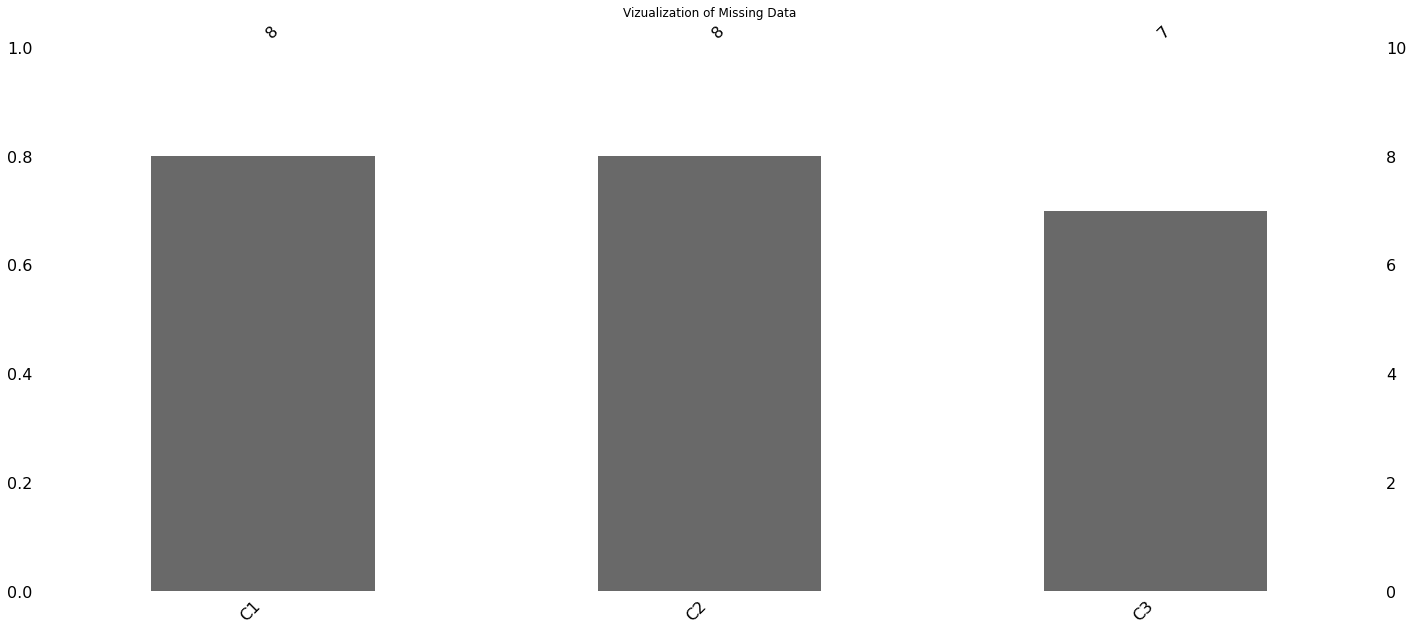

In [103]:
msno.bar(df)

plt.title("Vizualization of Missing Data")

plt.show()

For a real world example we will use planets dataset of seaborn.

In [8]:
df = sns.load_dataset("planets")
df.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [9]:
df.isnull().sum()

method              0
number              0
orbital_period     43
mass              522
distance          227
year                0
dtype: int64

<AxesSubplot:>

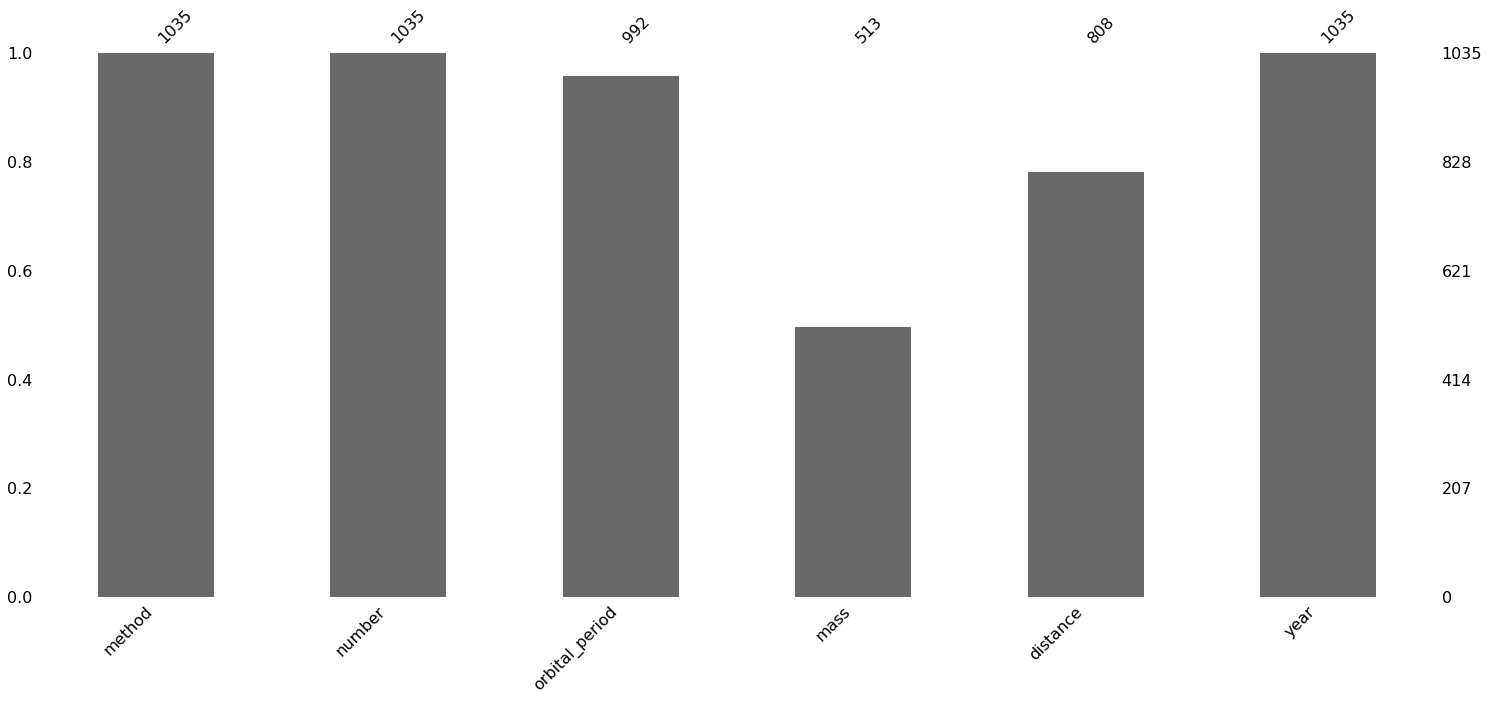

In [10]:
msno.bar(df)

## Data Standardization / Feature Scaling

### Normalization(0-1 Scaling)

Normalization is the process of scaling individual samples to have unit norm. Normalization typically means rescales the values into a range of [0,1].

We will use **normalize()** function for normalization.

In [15]:
C1 = np.array([1,5,43,54,22,85,19,35])
C2 = np.array([42,24,53,342,88,9,54,12])
C3 = np.array([13,53,57,43,76,18,45,35])
df = pd.DataFrame({"C1":C1,"C2":C2,"C3":C3})

df = df.astype(float)

In [16]:
df

,C1,C2,C3
0,1.0,42.0,13.0
1,5.0,24.0,53.0
2,43.0,53.0,57.0
3,54.0,342.0,43.0
4,22.0,88.0,76.0
5,85.0,9.0,18.0
6,19.0,54.0,45.0
7,35.0,12.0,35.0


### Standardization(Z Score Scaling)

The result of standardization (or Z-score normalization) is that the features will be rescaled so that they’ll have the properties of a standard normal distribution with

                                        μ=0 and σ=1

where μ is the mean (average) and σ is the standard deviation from the mean; standard scores (also called z scores) of the samples are calculated as follows:

                                          z=x−μσ
                                          
We will use **preprocessing.StandardScaler()** or **scale()** function to make standardization.                   

In [19]:
df = preprocessing.StandardScaler().fit_transform(df)

In [118]:
df.std(axis=0)

array([1., 1., 1.])

### Min-Max Scaling

An alternative standardization is scaling features to lie between a given minimum and maximum value, often between zero and one, or so that the maximum absolute value of each feature is scaled to unit size. This can be achieved using MinMaxScaler or MaxAbsScaler, respectively.

We will use **MinMaxScaler()** function for that.

In [23]:
C1 = np.array([1,5,43,54,22,85,19,35])
C2 = np.array([42,24,53,342,88,9,54,12])
C3 = np.array([13,53,57,43,76,18,45,35])
df = pd.DataFrame({"C1":C1,"C2":C2,"C3":C3})

df = df.astype(float)

In [24]:
df

,C1,C2,C3
0,1.0,42.0,13.0
1,5.0,24.0,53.0
2,43.0,53.0,57.0
3,54.0,342.0,43.0
4,22.0,88.0,76.0
5,85.0,9.0,18.0
6,19.0,54.0,45.0
7,35.0,12.0,35.0


In [25]:
mmscaler = preprocessing.MinMaxScaler()

In [26]:
mmscaler.fit_transform(df)

array([[0.        , 0.0990991 , 0.        ],
       [0.04761905, 0.04504505, 0.63492063],
       [0.5       , 0.13213213, 0.6984127 ],
       [0.63095238, 1.        , 0.47619048],
       [0.25      , 0.23723724, 1.        ],
       [1.        , 0.        , 0.07936508],
       [0.21428571, 0.13513514, 0.50793651],
       [0.4047619 , 0.00900901, 0.34920635]])

### Binary Transformation

An easy method of converting decimal to binary number equivalents is to write down the decimal number and to continually divide-by-2 (two) to give a result and a remainder of either a “1” or a “0” until the final result equals zero.

In [123]:
C1 = np.array([1,5,43,54,22,85,19,35])
C2 = np.array([42,24,53,342,88,9,54,12])
C3 = np.array([13,53,57,43,76,18,45,35])
df = pd.DataFrame({"C1":C1,"C2":C2,"C3":C3})

df = df.astype(float)

In [124]:
df

,C1,C2,C3
0,1.0,42.0,13.0
1,5.0,24.0,53.0
2,43.0,53.0,57.0
3,54.0,342.0,43.0
4,22.0,88.0,76.0
5,85.0,9.0,18.0
6,19.0,54.0,45.0
7,35.0,12.0,35.0


In [125]:
binarizer = preprocessing.Binarizer(threshold=10)

In [126]:
binarizer.fit_transform(df)

array([[0., 1., 1.],
       [0., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

## Variable Transformation

### Label Encoding

Encode categorical target labels with value between 0 and n_classes-1.

For a real world example, we will use tips dataset of Seaborn.

In [127]:
df = sns.load_dataset("tips")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [128]:
label_encoder = LabelEncoder()

In [129]:
label_encoder.fit_transform(df["sex"])

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0])

In [130]:
df["encoded_sex"] = label_encoder.fit_transform(df["sex"])

In [131]:
df.head()

,total_bill,tip,sex,smoker,day,time,size,encoded_sex
0,16.99,1.01,Female,No,Sun,Dinner,2,0
1,10.34,1.66,Male,No,Sun,Dinner,3,1
2,21.01,3.50,Male,No,Sun,Dinner,3,1
3,23.68,3.31,Male,No,Sun,Dinner,2,1
4,24.59,3.61,Female,No,Sun,Dinner,4,0


If we want a binary transformation, we can also use **cat.codes** function.

In [132]:
df["smoker_encoded"] = df["smoker"].cat.codes

In [133]:
df

,total_bill,tip,sex,smoker,day,time,size,encoded_sex,smoker_encoded
0,16.99,1.01,Female,No,Sun,Dinner,2,0,1
1,10.34,1.66,Male,No,Sun,Dinner,3,1,1
2,21.01,3.50,Male,No,Sun,Dinner,3,1,1
3,23.68,3.31,Male,No,Sun,Dinner,2,1,1
4,24.59,3.61,Female,No,Sun,Dinner,4,0,1
...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,1,1
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0,0
241,22.67,2.00,Male,Yes,Sat,Dinner,2,1,0
242,17.82,1.75,Male,No,Sat,Dinner,2,1,1


We can also do that for multiple classes but its not recommended. *One Hot Encoding* can be used for that.

In [134]:
df["day_encoded"] =label_encoder.fit_transform(df["day"])

In [135]:
df

,total_bill,tip,sex,smoker,day,time,size,encoded_sex,smoker_encoded,day_encoded
0,16.99,1.01,Female,No,Sun,Dinner,2,0,1,2
1,10.34,1.66,Male,No,Sun,Dinner,3,1,1,2
2,21.01,3.50,Male,No,Sun,Dinner,3,1,1,2
3,23.68,3.31,Male,No,Sun,Dinner,2,1,1,2
4,24.59,3.61,Female,No,Sun,Dinner,4,0,1,2
...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,1,1,1
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0,0,1
241,22.67,2.00,Male,Yes,Sat,Dinner,2,1,0,1
242,17.82,1.75,Male,No,Sat,Dinner,2,1,1,1


### One Hot Encoding

A one hot encoding is a representation of categorical variables as binary vectors.

This first requires that the categorical values be mapped to integer values.

For a real world example, we will use tips dataset of Seaborn.

In [136]:
df = sns.load_dataset("tips")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [137]:
pd.get_dummies(df,columns=["time"],prefix=["time"])

,total_bill,tip,sex,smoker,day,size,time_Lunch,time_Dinner
0,16.99,1.01,Female,No,Sun,2,0,1
1,10.34,1.66,Male,No,Sun,3,0,1
2,21.01,3.50,Male,No,Sun,3,0,1
3,23.68,3.31,Male,No,Sun,2,0,1
4,24.59,3.61,Female,No,Sun,4,0,1
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,3,0,1
240,27.18,2.00,Female,Yes,Sat,2,0,1
241,22.67,2.00,Male,Yes,Sat,2,0,1
242,17.82,1.75,Male,No,Sat,2,0,1
